In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from scipy.stats import pearsonr

In [2]:
save_dir = "results/sent_length_vs_(P)LL"
os.makedirs(save_dir, exist_ok=True)

In [3]:
def assign_significance(pval):
    if pval < 0.001:
        sig = "***"
    elif pval < 0.01:
        sig = "**"
    elif pval < 0.05:
        sig = "*"
    else:
        sig = "n.s."
    return sig

In [4]:
def get_plot_df(MODEL, DATASET, MASKING):
    # Read scores
    df = pd.read_csv(f'results/{DATASET}/{MODEL}/{DATASET}{MASKING}.csv')
    df["negative PLL score"] = -df["PLL score"]
    
    # Merge dataframes
    if DATASET in ["EventsAdapt", "Brown"]:
        df["nr. of words"] = df["sentence"].map(lambda x: len(x.split()))
    elif DATASET == "LibriSpeech":
        df["nr. of words"] = df["ref sentence"].map(lambda x: len(x.split()))
    else:
        raise NotImplementedError
    return df

In [5]:
plot_df = get_plot_df(MODEL="bert-base-cased", DATASET="EventsAdapt", MASKING="_OriginalPLL")
plot_df

,sentence id,sentence,PLL score,nr. of tokens,negative PLL score,nr. of words
0,tensor(0),The raider caught the illness.,-25.308203,9,25.308203,5
1,tensor(1),The illness caught the raider.,-28.228867,9,28.228867,5
2,tensor(2),The illness was caught by the raider.,-26.381300,11,26.381300,7
3,tensor(3),The raider was caught by the illness.,-29.998080,11,29.998080,7
4,tensor(4),The marauder contracted the disease.,-6.191896,11,6.191896,5
...,...,...,...,...,...,...
1559,tensor(1559),The plumber was devastated by the foreman.,-23.139163,12,23.139163,7
1560,tensor(1560),The sergeant identified the sniper.,-16.696263,8,16.696263,5
1561,tensor(1561),The sniper identified the sergeant.,-21.835777,8,21.835777,5
1562,tensor(1562),The sniper was identified by the sergeant.,-16.818658,10,16.818658,7


In [6]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)
plt.style.use('seaborn-dark-palette')

/tmp/ipykernel_42312/2354260861.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [7]:
RENAME_DICT_MODELS = {
    "gpt2-medium" : "GPT2-medium",
    "gpt2-xl" : "GPT2-xl",
    "bert-base-cased" : "BERT (base)",
    "bert-large-cased" : "BERT (large)",
    "roberta-base" : "RoBERTa (base)"
}

RENAME_DICT_METRICS = {
    "_OriginalPLL" : "| PLL-original",
    "_AdjustedPLL_l2r" : "| PLL-word-l2r",
    "_AdjustedPLL_mlm" : "| PLL-whole-word",
    "_AdjustedPLL_globall2r" : "| PLL-sentence-l2r",
    "" : ""
}

def rename(x):
    if x in RENAME_DICT_MODELS:
        return RENAME_DICT_MODELS[x]
    else:
        return RENAME_DICT_METRICS[x]

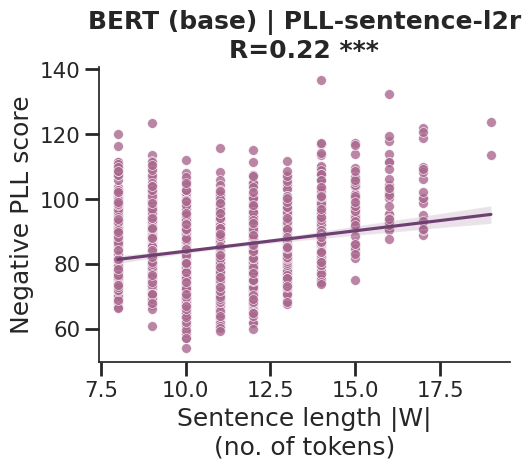

In [8]:
MODEL="bert-base-cased"
DATASET="EventsAdapt"
MASKING="_AdjustedPLL_globall2r"

plot_df = get_plot_df(MODEL=MODEL, DATASET=DATASET, MASKING=MASKING)

fig, ax = plt.subplots(figsize=(5.5, 5))
        
r, pval = pearsonr(plot_df["nr. of tokens"], plot_df["negative PLL score"])

sns.regplot(data=plot_df, x="nr. of tokens",
            y="negative PLL score", ax=ax,
            scatter_kws={"color": sns.cubehelix_palette(5)[2],
                         "edgecolor": 'w',
                         "linewidth":0.5,
                         "s":50},
            line_kws={"color": sns.cubehelix_palette(5)[3]}
           ).set_title(f'{rename(MODEL)} {rename(MASKING)}\nR={round(r,2)} {assign_significance(pval)}',
                      fontdict={"fontweight":"bold", "fontsize":18}, pad=7)
ax.set_xlabel(f'Sentence length |W|\n(no. of tokens)', fontsize=18)
ax.tick_params(axis='both', which='major', length=10, width=2)
ax.tick_params(axis='both', which='minor', length=10, width=2)
if not MODEL.startswith("gpt"):
    ax.set_ylabel('Negative PLL score',fontsize=18)
else:
    ax.set_ylabel('Negative LL score',fontsize=18)
            
plt.tight_layout()
plt.savefig(f"{save_dir}/{DATASET}_{MODEL}{MASKING}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/{DATASET}_{MODEL}{MASKING}.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/{DATASET}_{MODEL}{MASKING}.svg", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def correlate_length_score_subplots(GPT_VERSION, BERT_VERSION, DATASET, xaxis="nr. of tokens", sharey=False):
    MODEL_MASKING = [(GPT_VERSION, "")]
    maskings = ["_OriginalPLL", "_AdjustedPLL_l2r", "_AdjustedPLL_mlm"]
    berts = [BERT_VERSION] * len(maskings)
    MODEL_MASKING.extend(list(zip(berts,maskings)))
    
    fig, axes = plt.subplots(ncols=len(MODEL_MASKING), sharey=sharey, figsize=(18, 5)) #Width, height
    
    for ind, (MODEL, MASKING) in enumerate(MODEL_MASKING):
        plot_df = get_plot_df(MODEL, DATASET, MASKING)
        
        r, pval = pearsonr(plot_df[xaxis], plot_df["negative PLL score"])
#         if not "gpt" in MODEL:
#             axes[ind].set_facecolor("whitesmoke")
        
        sns.regplot(data=plot_df, x=xaxis,
                    y="negative PLL score", ax=axes[ind],
                    scatter_kws={"color": sns.cubehelix_palette(5)[2],
                                 "edgecolor": 'w',
                                 "linewidth":0.5,
                                 "s":50},
                    line_kws={"color": sns.cubehelix_palette(5)[3]}
                   ).set_title(f'{rename(MODEL)} {rename(MASKING)}\nR={round(r,2)} {assign_significance(pval)}',
                              fontdict={"fontweight":"bold", "fontsize":18}, pad=7)
        axes[ind].set_xlabel(f'Sentence length |W|\n(no. of tokens)', fontsize=18)
        axes[ind].tick_params(axis='both', which='major', length=10, width=2)#, labelsize=16)
        axes[ind].tick_params(axis='both', which='minor', length=10, width=2)#, labelsize=16)
        if not MODEL.startswith("gpt"):
            axes[ind].set_ylabel('Negative PLL score',fontsize=18)
        else:
            axes[ind].set_ylabel('Negative LL score',fontsize=18)
            
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{DATASET}_{GPT_VERSION}_{BERT_VERSION}_subplots_sharey={sharey}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/{DATASET}_{GPT_VERSION}_{BERT_VERSION}_subplots_sharey={sharey}.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/{DATASET}_{GPT_VERSION}_{BERT_VERSION}_subplots_sharey={sharey}.svg", dpi=300, bbox_inches='tight')
    plt.show()

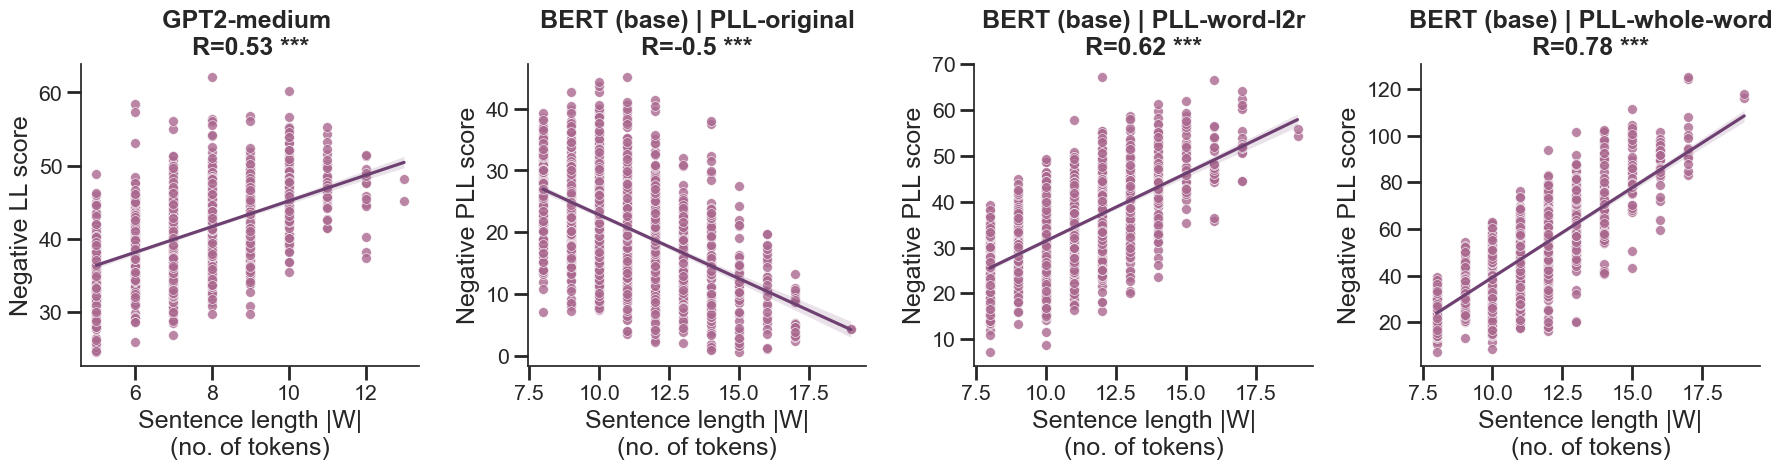

In [9]:
correlate_length_score_subplots("gpt2-medium", "bert-base-cased", "EventsAdapt")

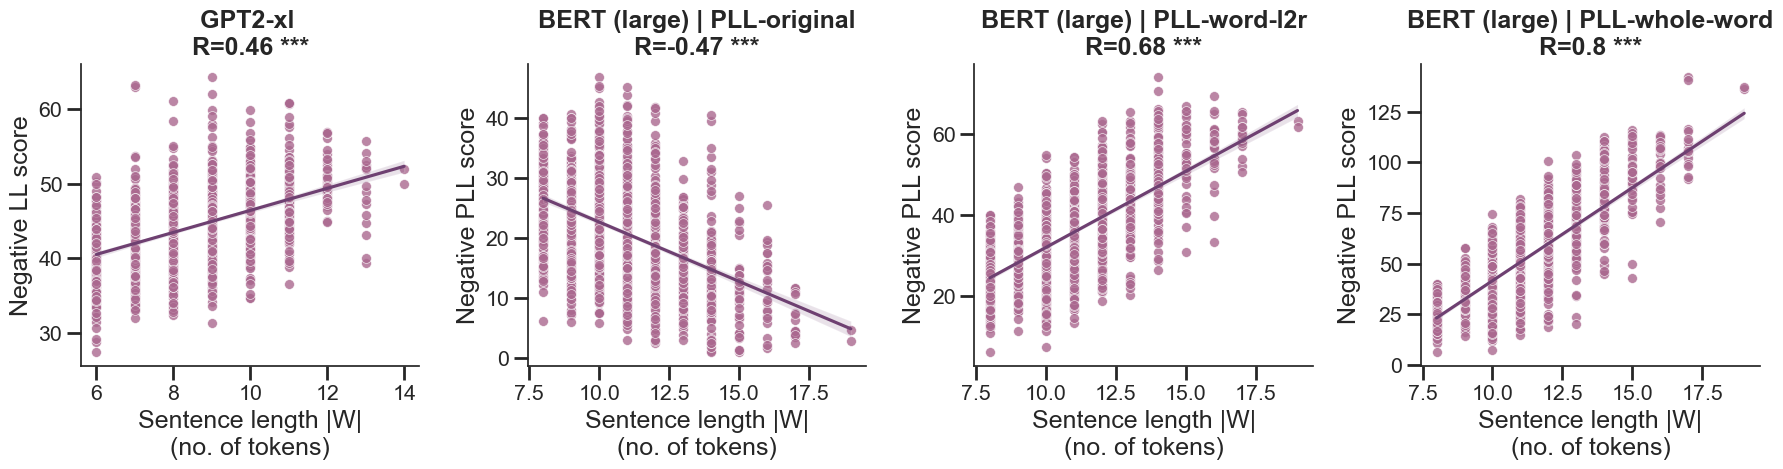

In [10]:
correlate_length_score_subplots("gpt2-xl", "bert-large-cased", "EventsAdapt")

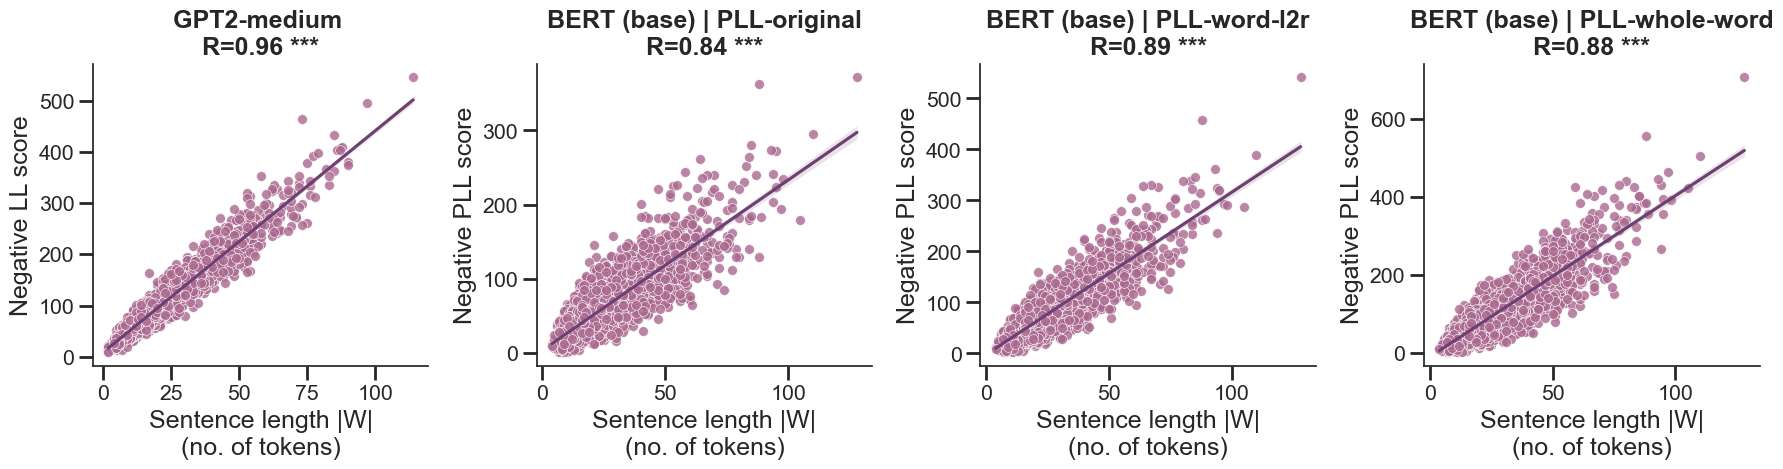

In [11]:
correlate_length_score_subplots("gpt2-medium", "bert-base-cased", "LibriSpeech")

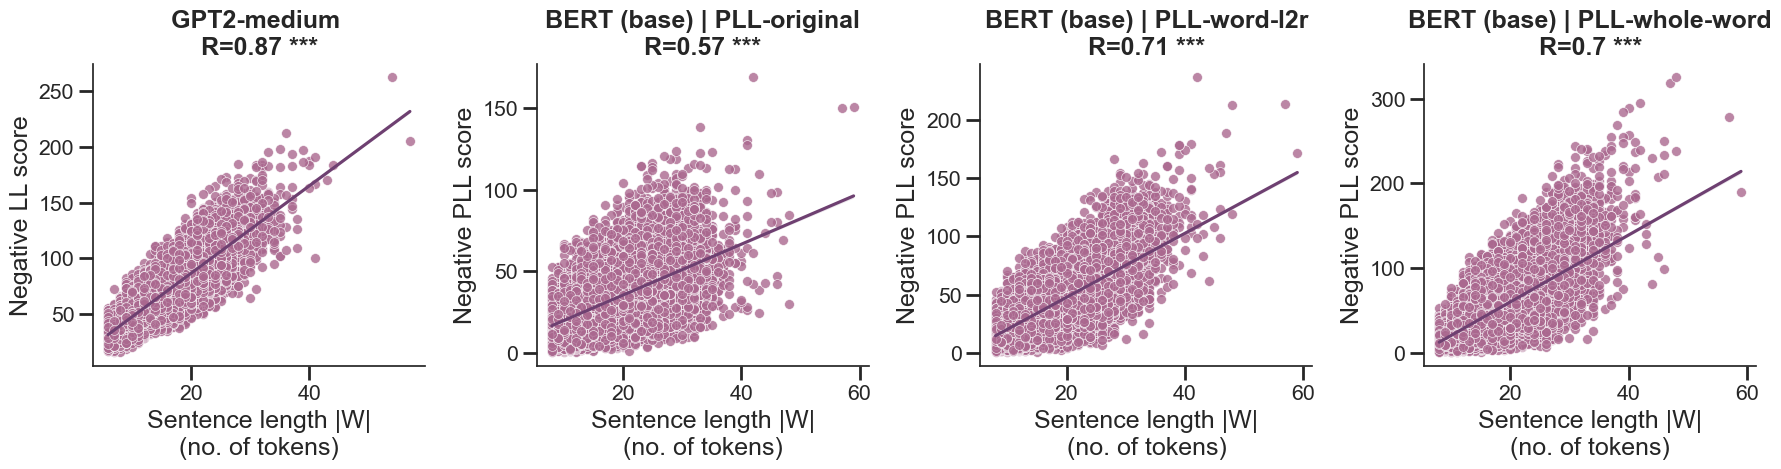

In [12]:
correlate_length_score_subplots("gpt2-medium", "bert-base-cased", "Brown")

# Line plots

In [13]:
def lineplots(BERT_VERSION, DATASET, sharey=False):
    MODEL_MASKING = []
    berts = [BERT_VERSION] * 3
    maskings = ["_OriginalPLL", "_AdjustedPLL_l2r", "_AdjustedPLL_mlm"]
    MODEL_MASKING.extend(list(zip(berts,maskings)))
    
    colors = sns.cubehelix_palette(len(MODEL_MASKING))
    #colors = colors[::-1]
    
    for ind, (MODEL, MASKING) in enumerate(MODEL_MASKING):
        plot_df = get_plot_df(MODEL, DATASET, MASKING)
        line_df = plot_df.groupby("nr. of tokens")["negative PLL score"].mean().reset_index()
        r, pval = pearsonr(plot_df["nr. of tokens"], plot_df["negative PLL score"])
        sns.lineplot(data=line_df, x="nr. of tokens", y="negative PLL score",
                    label=f"{rename(MODEL)} {rename(MASKING)} | R={round(r,2)} {assign_significance(pval)}",
                    color=colors[ind])
    plt.xlabel(f'Sentence length |W|')
    plt.ylabel('Negative (P)LL score')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{DATASET}_{BERT_VERSION}_lineplot.png", dpi=300, bbox_inches='tight')
    plt.show()

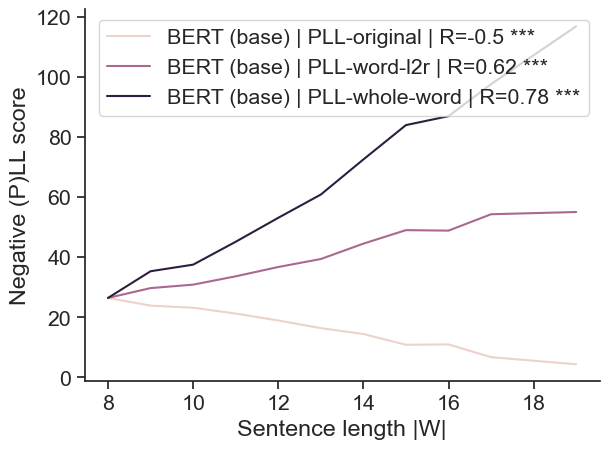

In [14]:
lineplots("bert-base-cased", "EventsAdapt")

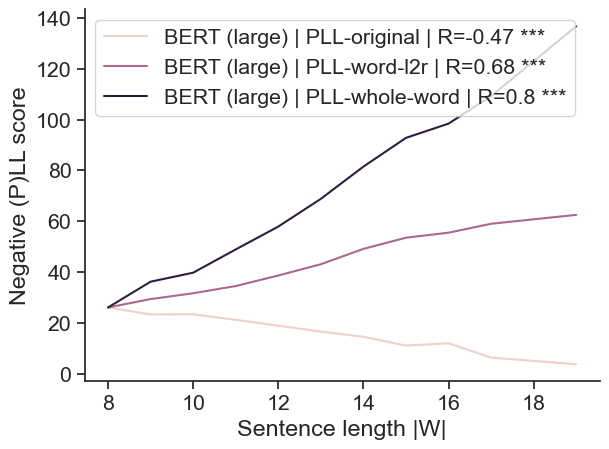

In [15]:
lineplots("bert-large-cased", "EventsAdapt")

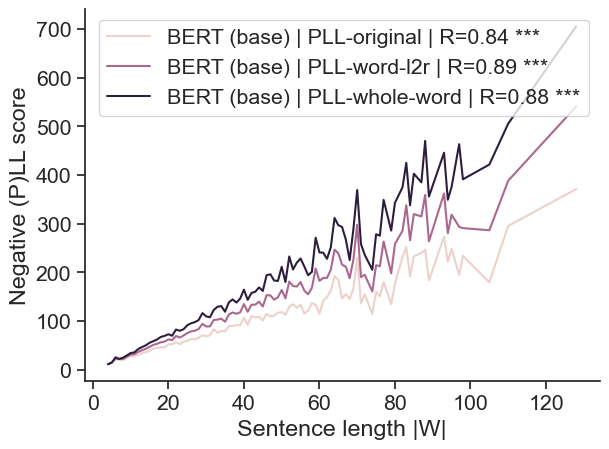

In [16]:
lineplots("bert-base-cased", "LibriSpeech")